# Clustering

Load the `dataset1.csv` and explore the data, showing size, structure and histograms of numeric data; show the histogram of the frequencies of the class labels, contained in the "y" column.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
url = './exam-superv.csv'
df = pd.read_csv(url)

# show structure
df.head()

,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


In [56]:
df.describe()

,0,1,y,2
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,0.507500,2.494236
std,0.804770,0.507227,0.500152,0.589235
min,0.343023,0.509424,0.000000,1.500260
25%,1.806657,1.809635,0.000000,1.974389
50%,2.744439,1.983524,1.000000,2.469778
75%,3.092275,2.201484,1.000000,2.995198
max,3.529782,3.647299,1.000000,3.498523


In [57]:
# show size
print("The dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The dataset has 1200 rows and 4 columns


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

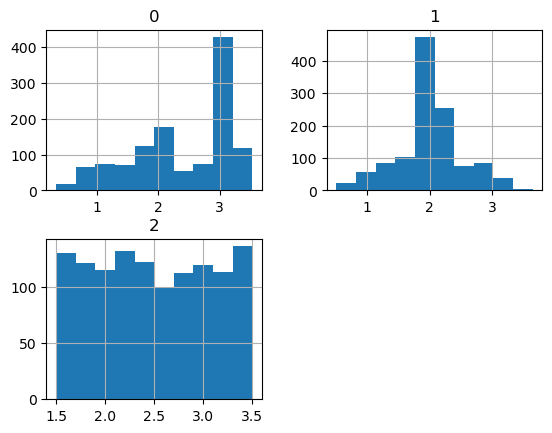

In [58]:
# histogram of numeric data
df.drop(columns='y', axis=1).hist()

<Axes: xlabel='y'>

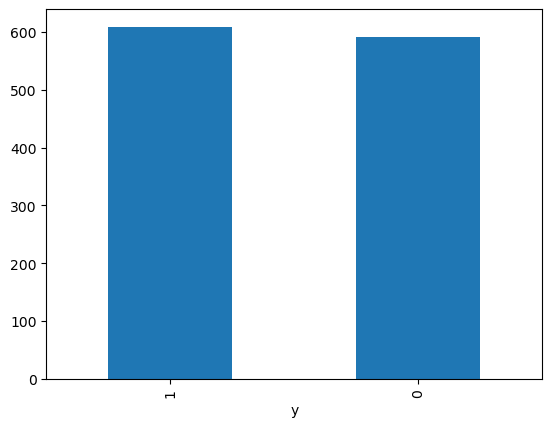

In [59]:
# show histogram of class labels
df['y'].value_counts().plot(kind='bar')

Drop the column "y" and find the best clustering scheme and hyper-parameters able to reproduce the y column (hint: drop the columns with little correlation to "y").

In [60]:
df.corr()


,0,1,y,2
0,1.000000,-0.018977,0.874676,0.004796
1,-0.018977,1.000000,-0.000336,0.023921
y,0.874676,-0.000336,1.000000,0.042789
2,0.004796,0.023921,0.042789,1.000000


We can see that the columns "1" and "2" have little correlation with y, so i can drop them

In [61]:
target = 'y'

X = df.drop(columns=[target, '1', '2'], axis=1)
y = df[target]

print("Now, the new dataset has {} rows and {} columns".format(X.shape[0], X.shape[1]))

Now, the new dataset has 1200 rows and 1 columns


In [62]:
# first try: use KMeans

from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

params = [{'n_clusters': list(range(2,11))}]

pg = list(ParameterGrid(param_grid=params))

silhouette = []
inertia = []

for i in range(len(pg)):
    km_model = KMeans(**(pg[i]))
    y_pred_km = km_model.fit_predict(X)
    
    silhouette.append(silhouette_score(X, y_pred_km))
    inertia.append(km_model.inertia_)

In order to decide the right number of clusters, let's plot the inertia and silhouette graphs

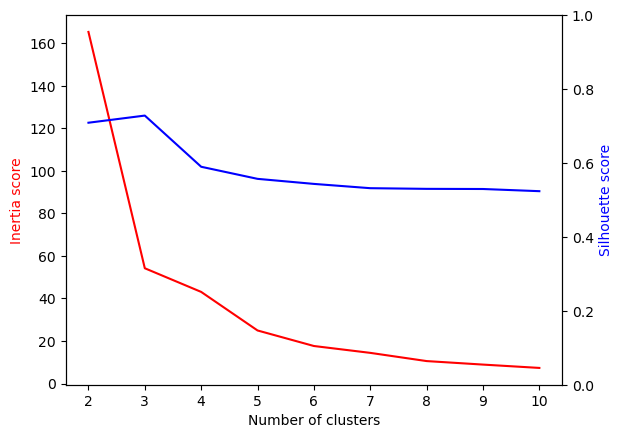

In [63]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(list(range(2,11)), inertia, color='red')
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia score", color='red')

ax2.plot(list(range(2,11)), silhouette, color='blue')
ax2.set_ylabel("Silhouette score", color='blue')
ax2.set_ylim(0,1)

plt.show()

In order to decide the right number of clusters, we need to focus on the k value in which the inertia's slope is decreasing and the silhouette score has a maximum point. 

We might find this condition in $k=3$.


In [64]:
# train and predict using the correct k

K = 3

km_model = KMeans(n_clusters=K)
y_pred_km = km_model.fit_predict(X)

silhouette_k = silhouette_score(X, y_pred_km)
inertia_k = km_model.inertia_

print("The KMeans with K={} clusters, produces:\n Inertia = {},\n Silhouette score = {}".format(
    K, inertia_k, silhouette_k
))


The KMeans with K=3 clusters, produces:
 Inertia = 54.223571847855716,
 Silhouette score = 0.7281970462432884


In [70]:
# second try: Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

params = [{'n_clusters': list(range(2,11)), 
           'linkage': ['ward', 'single', 'complete', 'average']
         }]

pg = list(ParameterGrid(params))
results = pd.DataFrame(columns=["Linkage", "N_clusters", "silhouette_score"])

for i in range(len(pg)):
    ac_model = AgglomerativeClustering(**(pg[i]))
    y_pred_ac = ac_model.fit_predict(X)

    results.loc[len(results)] = [pg[i]['linkage'], pg[i]['n_clusters'], silhouette_score(X, y_pred_ac)]

In [71]:
results.sort_values(by=['silhouette_score'], ascending=False).head()

,Linkage,N_clusters,silhouette_score
1,ward,3,0.728211
28,average,3,0.719239
27,average,2,0.710944
0,ward,2,0.708720
29,average,4,0.688199


As we see, even with Agglomerative Clustering we obtain the best silhouette score by setting $K=3$ and choosing the `ward` linkage.

In [74]:
ac_fin = AgglomerativeClustering(n_clusters=3, linkage='ward')
y_pred_ac = ac_fin.fit_predict(X)

print("silhouette score of Agglomerative Clustering with k=3 and linkage=\'ward\' is ", silhouette_score(X, y_pred_ac))

silhouette score of Agglomerative Clustering with k=3 and linkage='ward' is  0.7282114626229805


The two cluster algorithms are almost identical wrt the silhouette score and number of clusters.

show the difference between the original "y" column and the labels generated by the clustering, it can be expressed as "accuracy", produce also the confusion matrix.

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

km_accuracy = accuracy_score(y, y_pred_km)
ac_accuracy = accuracy_score(y, y_pred_ac)

print("The accuracy score for the KMeans is {}%.\nThe accuracy score for Agglomerative Clustering is {}%".format(km_accuracy *100, ac_accuracy*100))

The accuracy score for the KMeans is 83.25%.
The accuracy score for Agglomerative Clustering is 83.25%


Confusion Matrix of KMeans:


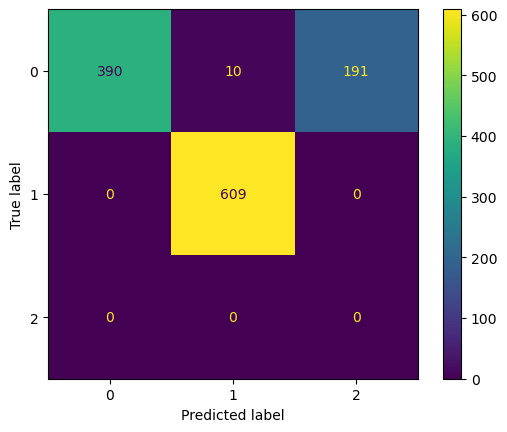

Confusion Matrix of Agglomerative Clustering:


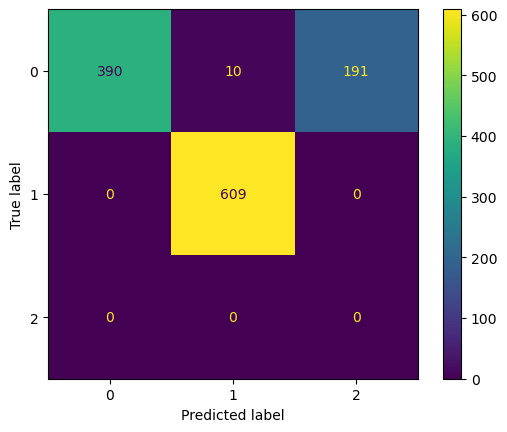

In [79]:
km_cm = confusion_matrix(y, y_pred_km)
ac_cm = confusion_matrix(y, y_pred_ac)

km_disp = ConfusionMatrixDisplay(confusion_matrix=km_cm, display_labels=np.unique(y_pred_km))
ac_disp = ConfusionMatrixDisplay(confusion_matrix=ac_cm, display_labels=np.unique(y_pred_ac))

print("Confusion Matrix of KMeans:")
km_disp.plot()

plt.show()
print("Confusion Matrix of Agglomerative Clustering:")
ac_disp.plot()

plt.show()

As we see, both clustering algorithms are pretty good in general, except for labelling correctly the label "2".

Apply the same transformation to `dataset2`, the apply the best clustering scheme and hyper parameters and plot the data with the assigned lables.